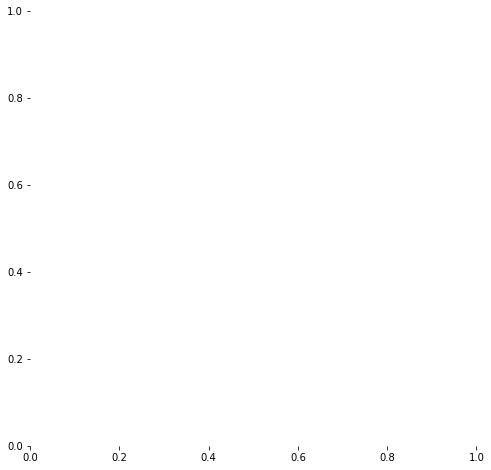

Optimizing variational parameters...
Iteration 0 lower bound 2.0432682037353516


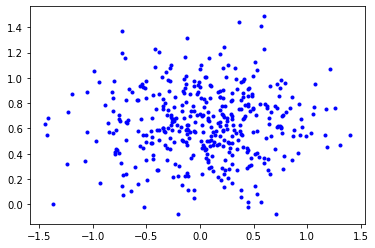

Iteration 1 lower bound 4.252288341522217


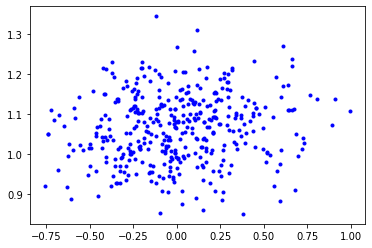

Iteration 2 lower bound 5.813729763031006


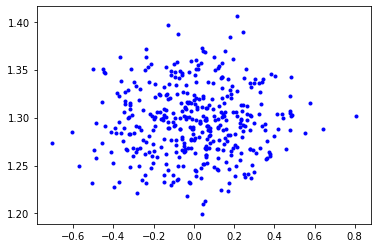

Iteration 3 lower bound 6.764106273651123


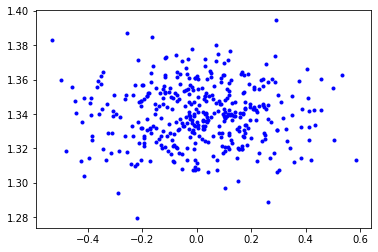

Iteration 4 lower bound 7.19527006149292


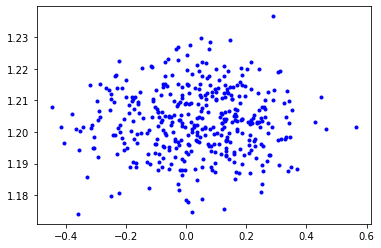

Iteration 5 lower bound 7.031243324279785


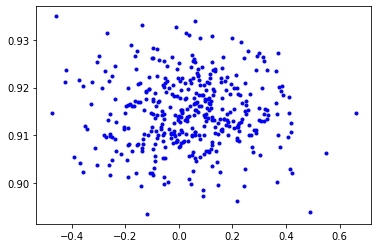

Iteration 6 lower bound 6.544520854949951


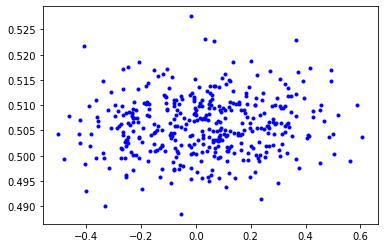

Iteration 7 lower bound 5.929712772369385


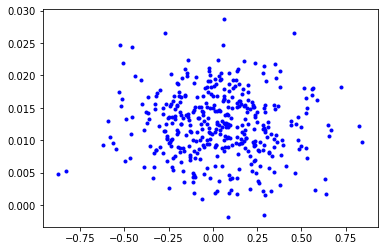

Iteration 8 lower bound 5.412162780761719


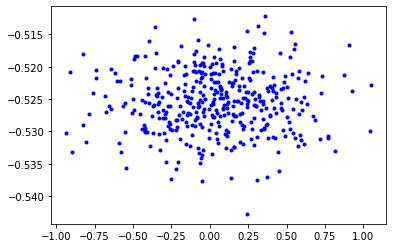

Iteration 9 lower bound 5.425853729248047


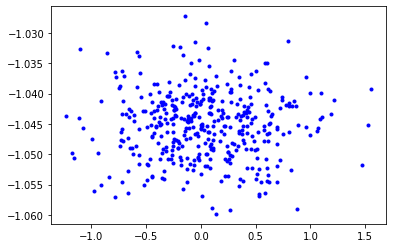

Iteration 10 lower bound 6.646640300750732


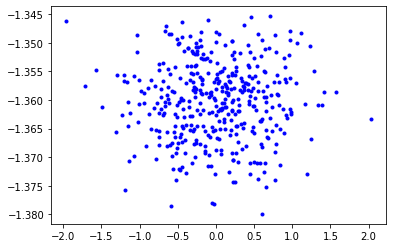

Iteration 11 lower bound 5.118529319763184


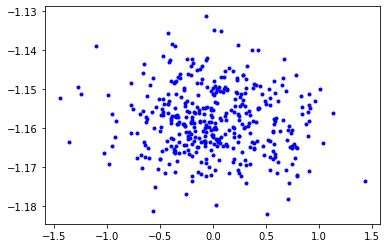

Iteration 12 lower bound 4.50090217590332


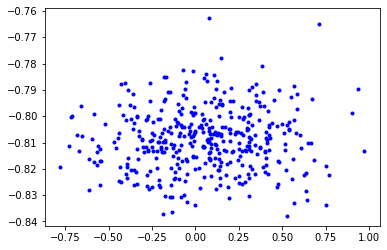

Iteration 13 lower bound 4.260859489440918


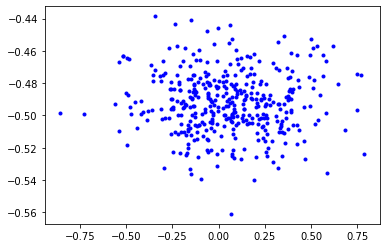

Iteration 14 lower bound 4.050412178039551


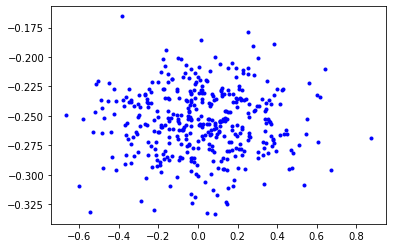

Iteration 15 lower bound 3.7964348793029785


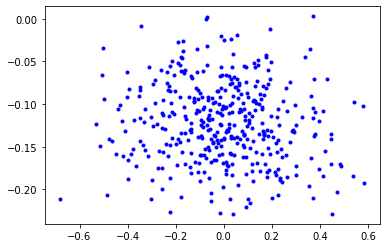

Iteration 16 lower bound 3.1705400943756104


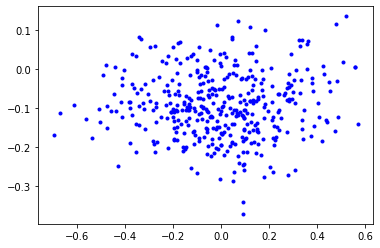

Iteration 17 lower bound 2.3260703086853027


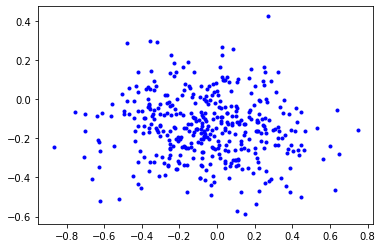

Iteration 18 lower bound 1.4707605838775635


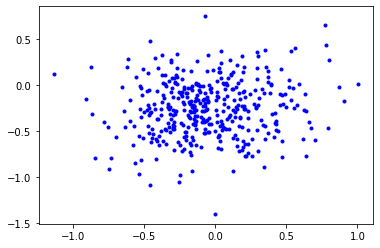

Iteration 19 lower bound 0.9037214517593384


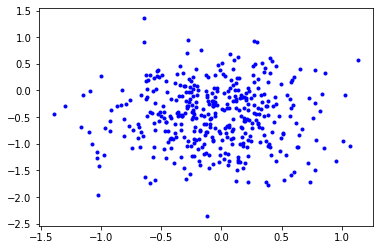

Iteration 20 lower bound 3.876971960067749


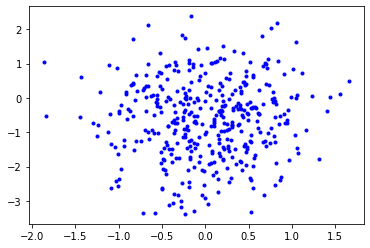

Iteration 21 lower bound 0.7494949698448181


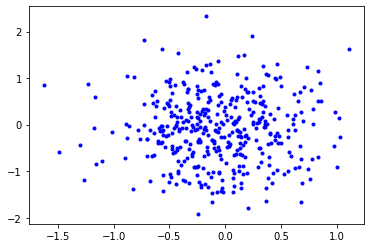

Iteration 22 lower bound 1.470349907875061


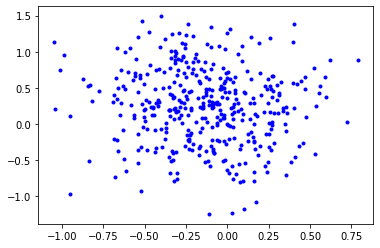

Iteration 23 lower bound 2.2345027923583984


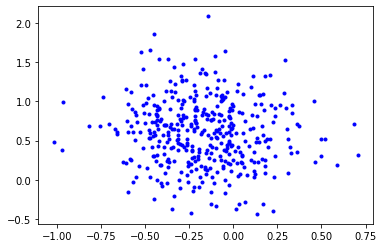

Iteration 24 lower bound 2.5474252700805664


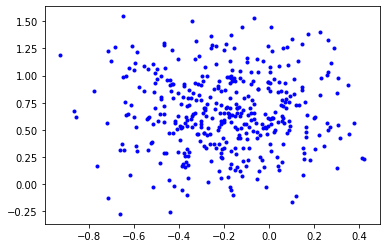

Iteration 25 lower bound 2.5647881031036377


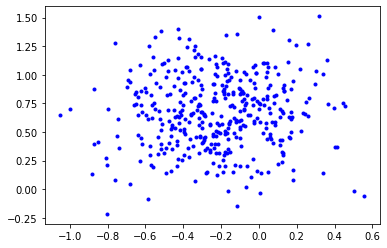

Iteration 26 lower bound 2.174891710281372


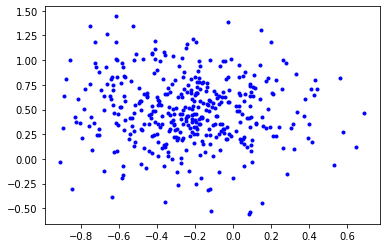

Iteration 27 lower bound 1.412583589553833


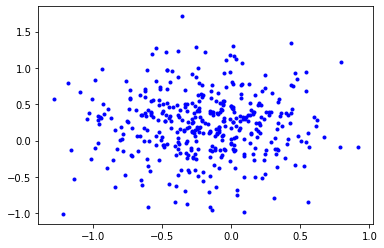

Iteration 28 lower bound 0.9378269910812378


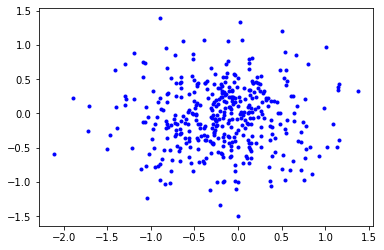

Iteration 29 lower bound 1.2245748043060303


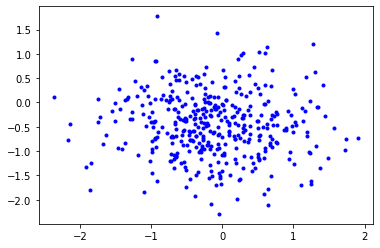

Iteration 30 lower bound 1.2766832113265991


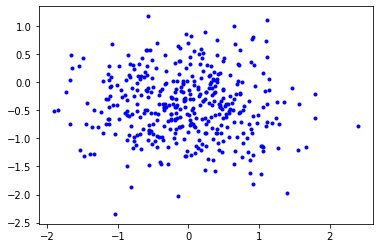

Iteration 31 lower bound 0.8735716342926025


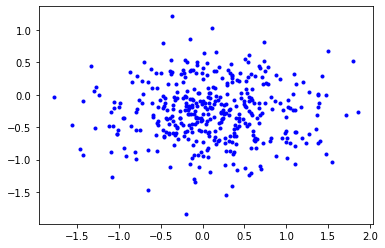

Iteration 32 lower bound 1.0305583477020264


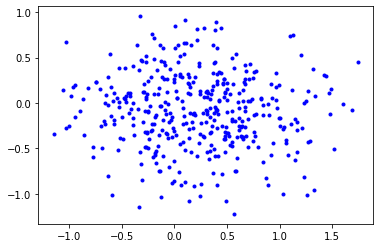

Iteration 33 lower bound 1.0462809801101685


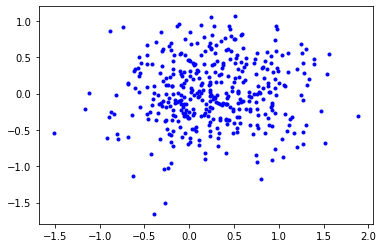

Iteration 34 lower bound 1.08694589138031


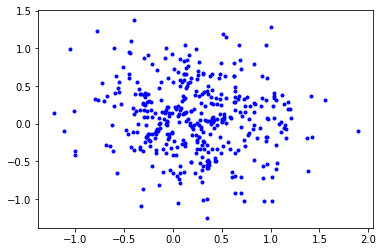

Iteration 35 lower bound 0.949355959892273


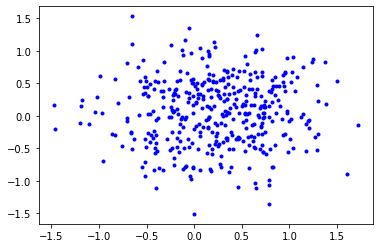

Iteration 36 lower bound 0.8207982182502747


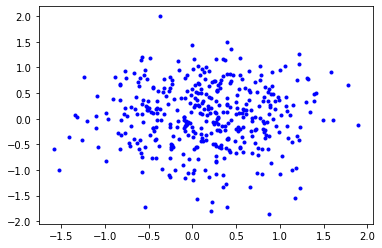

Iteration 37 lower bound 0.8386555314064026


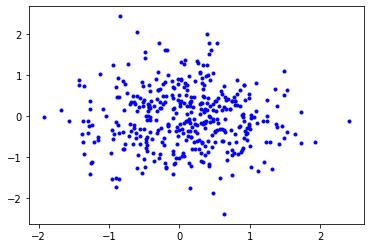

Iteration 38 lower bound 0.8720384836196899


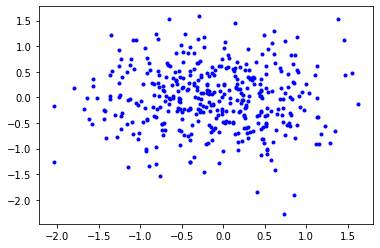

Iteration 39 lower bound 0.9197825193405151


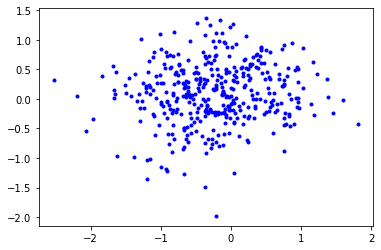

Iteration 40 lower bound 0.9211729764938354


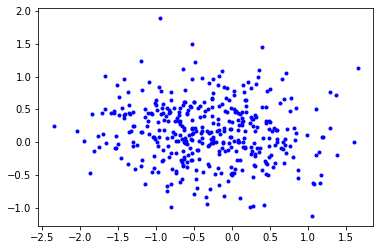

Iteration 41 lower bound 0.9050629734992981


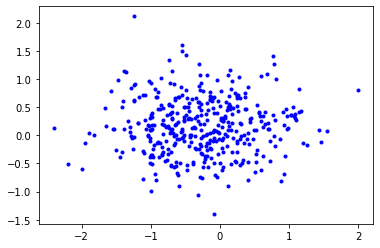

Iteration 42 lower bound 0.8956185579299927


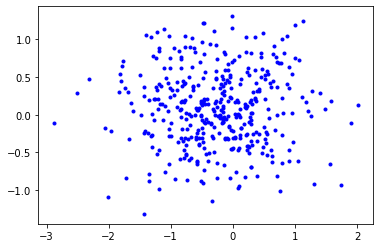

Iteration 43 lower bound 0.7679847478866577


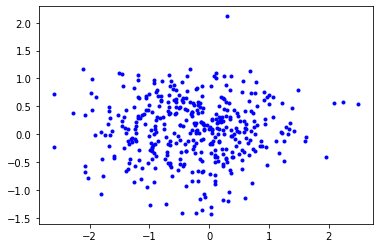

Iteration 44 lower bound 0.872096836566925


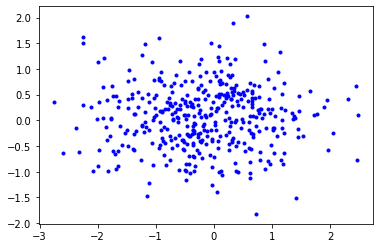

Iteration 45 lower bound 0.809551477432251


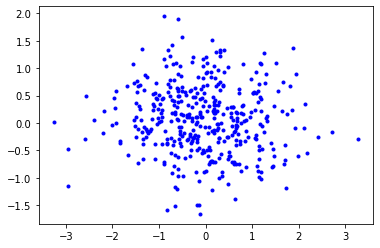

Iteration 46 lower bound 0.8589733839035034


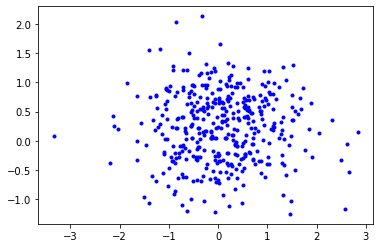

Iteration 47 lower bound 0.8610074520111084


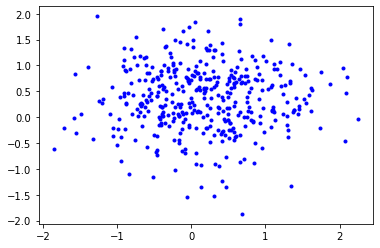

Iteration 48 lower bound 0.8833646178245544


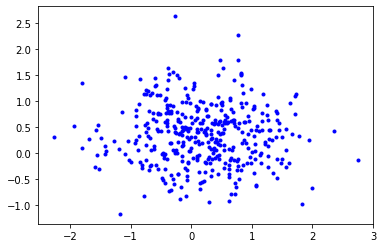

Iteration 49 lower bound 0.74452805519104


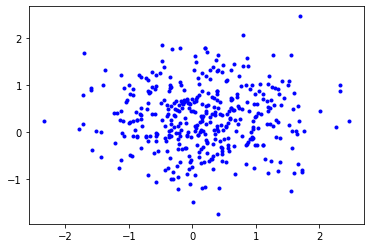

Iteration 50 lower bound 0.7743132710456848


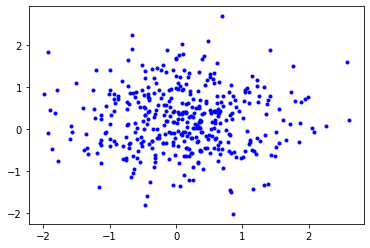

Iteration 51 lower bound 0.8023614883422852


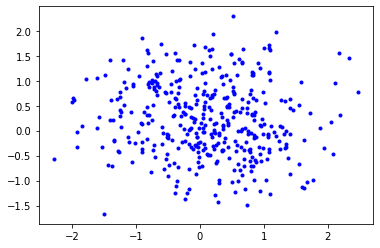

Iteration 52 lower bound 0.924930989742279


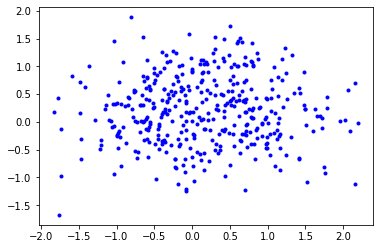

Iteration 53 lower bound 0.8431097269058228


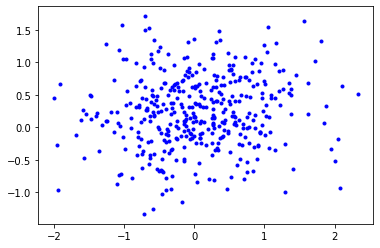

Iteration 54 lower bound 0.8543647527694702


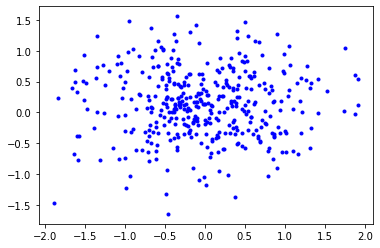

Iteration 55 lower bound 0.7824620008468628


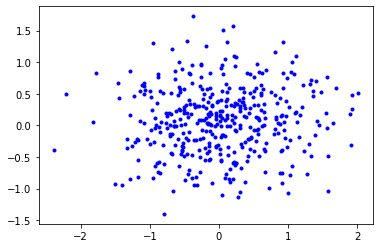

Iteration 56 lower bound 0.7522991895675659


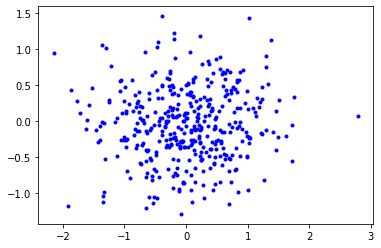

Iteration 57 lower bound 0.7452605366706848


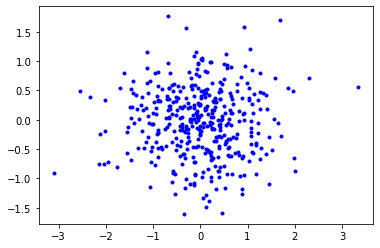

Iteration 58 lower bound 0.6722311973571777


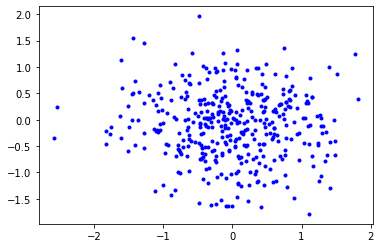

Iteration 59 lower bound 0.8693646192550659


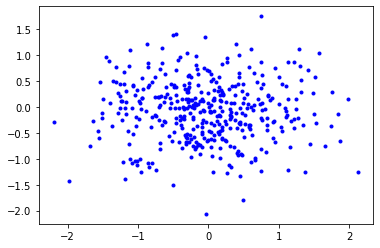

Iteration 60 lower bound 0.7828403115272522


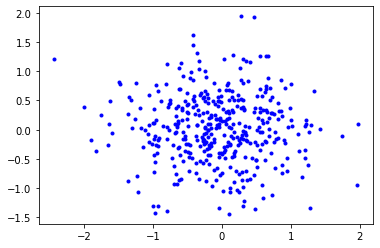

Iteration 61 lower bound 0.7699776291847229


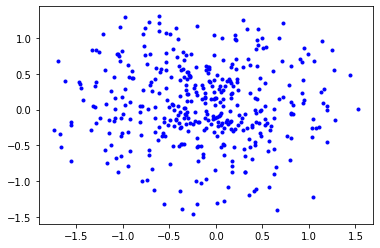

Iteration 62 lower bound 0.8404900431632996


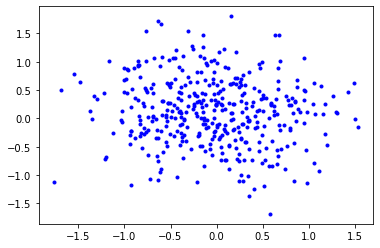

Iteration 63 lower bound 0.7686567306518555


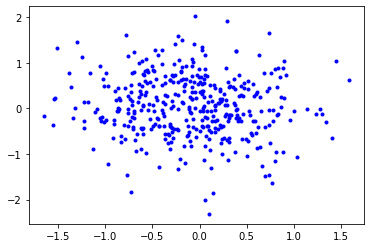

Iteration 64 lower bound 0.7533299326896667


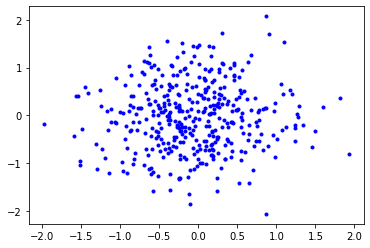

Iteration 65 lower bound 0.9205461740493774


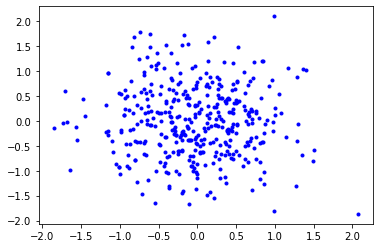

Iteration 66 lower bound 0.7703542113304138


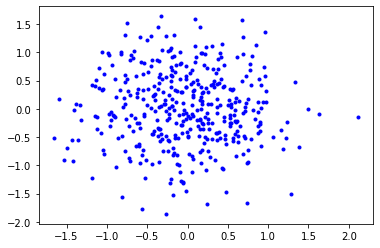

Iteration 67 lower bound 0.8304856419563293


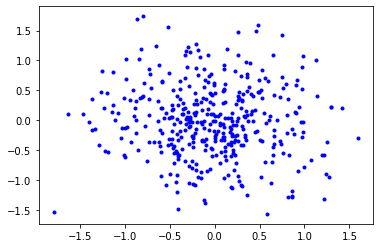

Iteration 68 lower bound 0.9015546441078186


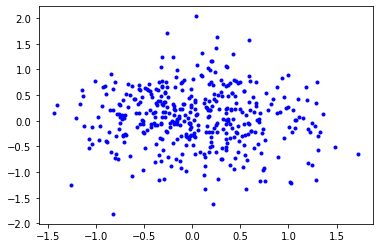

Iteration 69 lower bound 0.8572922945022583


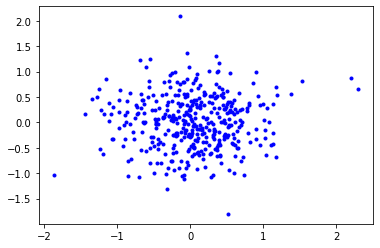

Iteration 70 lower bound 0.7622965574264526


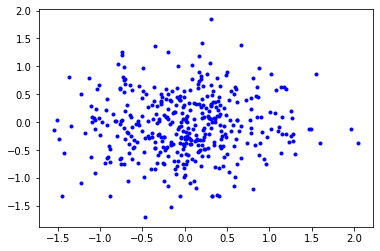

Iteration 71 lower bound 0.6769797205924988


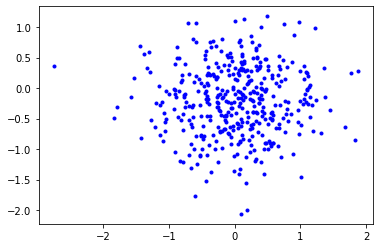

Iteration 72 lower bound 1.0042822360992432


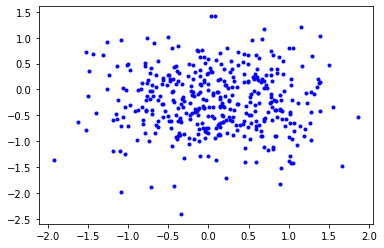

Iteration 73 lower bound 0.8482146263122559


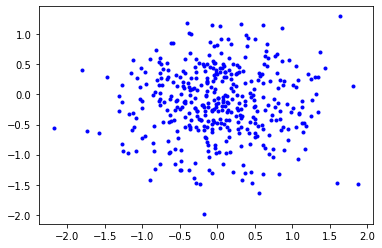

Iteration 74 lower bound 0.7250018119812012


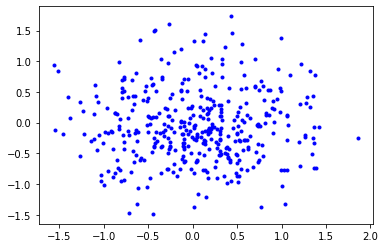

Iteration 75 lower bound 0.7056084871292114


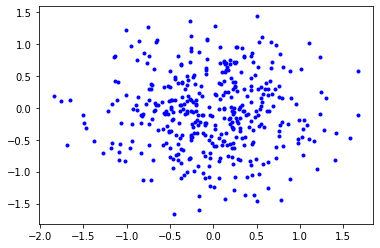

Iteration 76 lower bound 0.8254292607307434


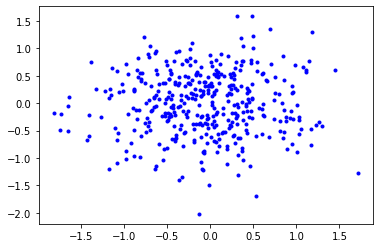

Iteration 77 lower bound 0.7735467553138733


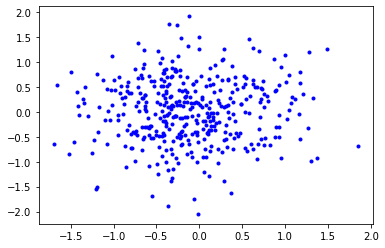

Iteration 78 lower bound 0.9212131500244141


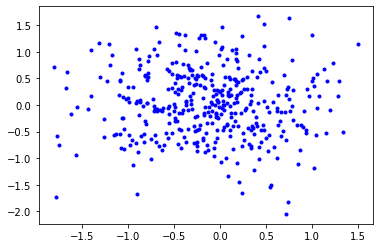

Iteration 79 lower bound 0.8044348955154419


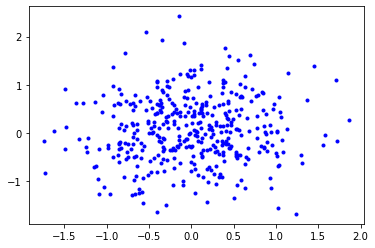

Iteration 80 lower bound 0.7919825315475464


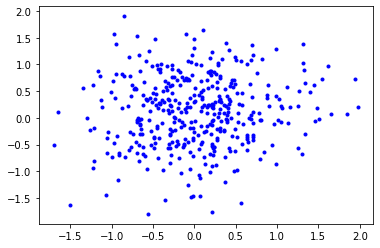

Iteration 81 lower bound 0.7817862629890442


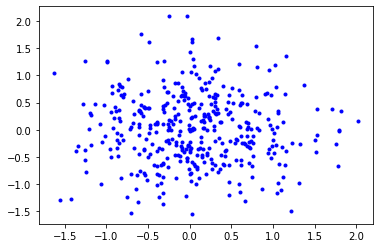

Iteration 82 lower bound 0.7851700186729431


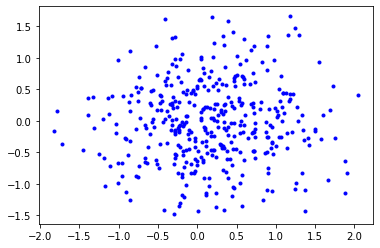

Iteration 83 lower bound 0.8097768425941467


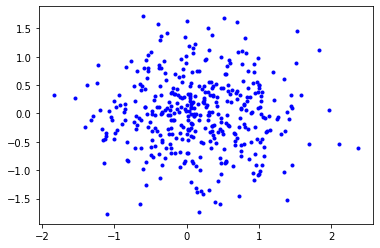

Iteration 84 lower bound 0.8175934553146362


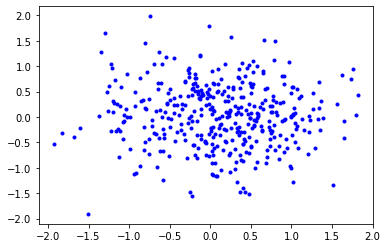

Iteration 85 lower bound 0.702644944190979


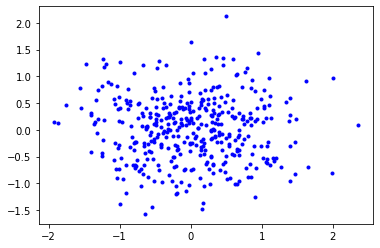

Iteration 86 lower bound 0.8456353545188904


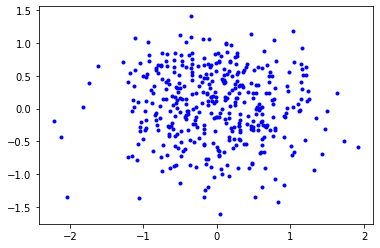

Iteration 87 lower bound 0.74698406457901


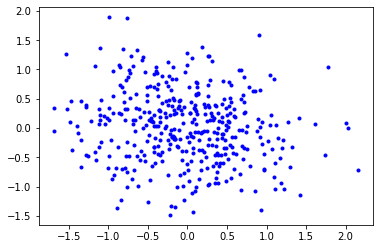

Iteration 88 lower bound 0.8048310875892639


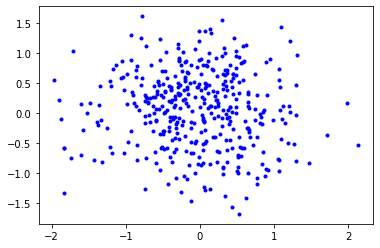

Iteration 89 lower bound 0.7667002081871033


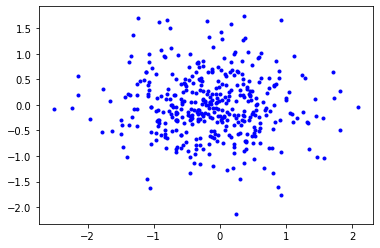

Iteration 90 lower bound 0.8216765522956848


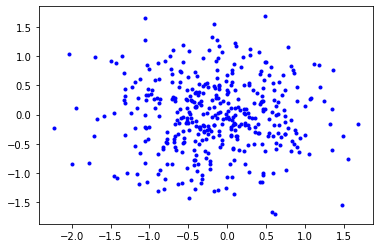

Iteration 91 lower bound 0.8037058115005493


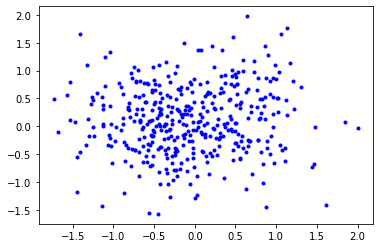

Iteration 92 lower bound 0.8293807506561279


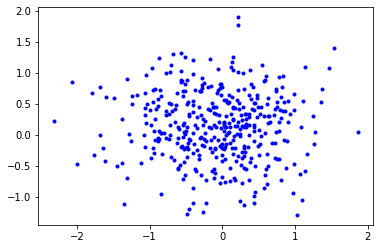

Iteration 93 lower bound 0.7896146774291992


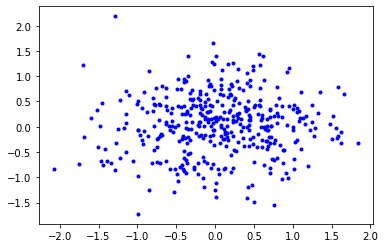

Iteration 94 lower bound 0.833929181098938


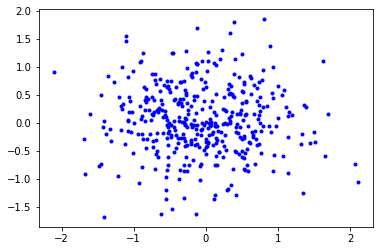

Iteration 95 lower bound 0.8780709505081177


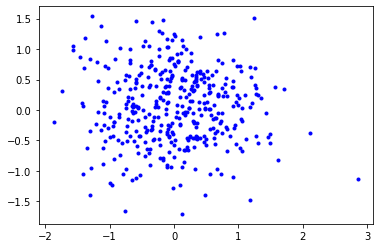

Iteration 96 lower bound 0.7169874906539917


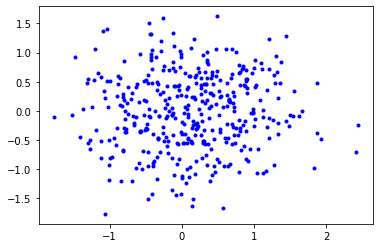

Iteration 97 lower bound 0.7107789516448975


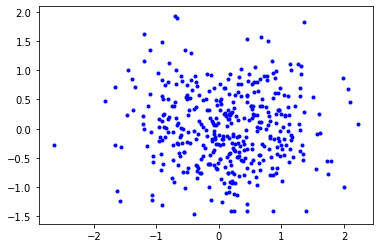

Iteration 98 lower bound 0.919532299041748


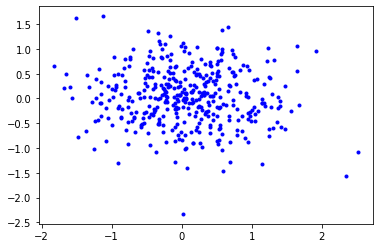

Iteration 99 lower bound 0.6950183510780334


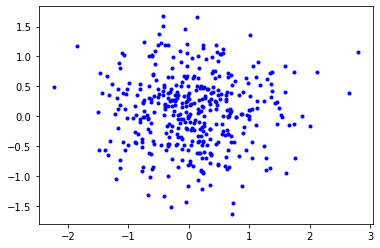

In [11]:
"""Automatic differentiation variational inference in Numpy and JAX.
This demo fits a Gaussian approximation to an intractable, unnormalized
density, by differentiating through a Monte Carlo estimate of the
variational evidence lower bound (ELBO)."""
%matplotlib inline

from functools import partial
import matplotlib.pyplot as plt

from jax.api import jit, grad, vmap
from jax import random
from jax.experimental import optimizers
import jax.numpy as jnp
import jax.scipy.stats.norm as norm


# ========= Functions to define the evidence lower bound. =========

def diag_gaussian_sample(rng, mean, log_std):
    # Take a single sample from a diagonal multivariate Gaussian.
    return mean + jnp.exp(log_std) * random.normal(rng, mean.shape)

def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate a single point on a diagonal multivariate Gaussian.
    return jnp.sum(vmap(norm.logpdf)(x, mean, jnp.exp(log_std)))

def elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return logprob(sample) - diag_gaussian_logpdf(sample, mean, log_std)

def batch_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = vmap(partial(elbo, logprob), in_axes=(0, None, None))
    return jnp.mean(vectorized_elbo(rngs, *params))


# ========= Helper function for plotting. =========

@partial(jit, static_argnums=(0, 1, 2, 4))
def _mesh_eval(func, x_limits, y_limits, params, num_ticks):
    # Evaluate func on a 2D grid defined by x_limits and y_limits.
    x = jnp.linspace(*x_limits, num=num_ticks)
    y = jnp.linspace(*y_limits, num=num_ticks)
    X, Y = jnp.meshgrid(x, y)
    xy_vec = jnp.stack([X.ravel(), Y.ravel()]).T
    zs = vmap(func, in_axes=(0, None))(xy_vec, params)
    return X, Y, zs.reshape(X.shape)

def mesh_eval(func, x_limits, y_limits, params, num_ticks=101):
    return _mesh_eval(func, x_limits, y_limits, params, num_ticks)

# ========= Define an intractable unnormalized density =========

def funnel_log_density(params):
    return norm.logpdf(params[0], 0, jnp.exp(params[1])) + \
           norm.logpdf(params[1], 0, 1.35)



num_samples = 400

@jit
def objective(params, t):
    rng = random.PRNGKey(t)
    return -batch_elbo(funnel_log_density, rng, params, num_samples)

# Set up figure.
fig = plt.figure(figsize=(8,8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
plt.show(block=False)
x_limits = [-2, 2]
y_limits = [-4, 2]
target_dist = lambda x, _: jnp.exp(funnel_log_density(x))
approx_dist = lambda x, params: jnp.exp(diag_gaussian_logpdf(x, *params))

def callback(params, t):
    print("Iteration {} lower bound {}".format(t, objective(params, t)))

    plt.cla()
    X, Y, Z = mesh_eval(target_dist, x_limits, y_limits, 1)
    ax.contour(X, Y, Z, cmap='summer')
    X, Y, Z = mesh_eval(approx_dist, x_limits, y_limits, params)
    ax.contour(X, Y, Z, cmap='winter')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_yticks([])
    ax.set_xticks([])

    # Plot random samples from variational distribution.
    # Here we clone the rng used in computing the objective
    # so that we can show exactly the same samples.
    rngs = random.split(random.PRNGKey(t), num_samples)
    samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)
    ax.plot(samples[:, 0], samples[:, 1], 'b.')

    plt.plot(samples[:, 0], samples[:, 1], 'b.')
    plt.show()
    #plt.pause(1.0/60.0)


# Set up optimizer.
D = 2
init_mean = jnp.zeros(D)
init_std  = jnp.zeros(D)
init_params = (init_mean, init_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)


# Main loop.
print("Optimizing variational parameters...")
for t in range(100):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)
plt.show(block=True)

In [9]:
plt.show()